In [93]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import contextily as ctx
import scipy.stats as stats
import scipy.interpolate

In [2]:
#Define variable to store current year
#curr_y = datetime.now().year
curr_y = pd.to_datetime("today").year
curr_y

2022

In [3]:
sites_fn = 'snotel_conus_baker.json'
snwd_pkl_fn = 'snotel_snwd_d_baker.pkl'
wteq_pkl_fn = 'snotel_wteq_d_baker.pkl'

In [4]:
#Note: geojson uses integer index, so need the `set_index` below
sites_gdf_all = gpd.read_file(sites_fn).set_index('index')
sites_gdf_all.head()

,code,name,network,elevation_m,site_property,geometry
index,,,,,,
SNOTEL:910_WA_SNTL,910_WA_SNTL,Elbow Lake,SNOTEL,926.591980,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.90893 48.69092)
SNOTEL:999_WA_SNTL,999_WA_SNTL,Marten Ridge,SNOTEL,1072.895996,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.69823 48.76292)
SNOTEL:1011_WA_SNTL,1011_WA_SNTL,MF Nooksack,SNOTEL,1514.855957,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.92951 48.82453)
SNOTEL:909_WA_SNTL,909_WA_SNTL,Wells Creek,SNOTEL,1228.343994,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.78976 48.86610)


In [5]:
sites_gdf_proj = sites_gdf_all.to_crs(32610)

In [6]:
snwd_df = pd.read_pickle(snwd_pkl_fn)
wteq_df = pd.read_pickle(wteq_pkl_fn)

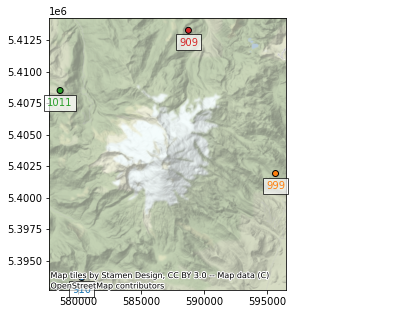

In [7]:
color_list = ['C%i' % i for i in range(len(sites_gdf_proj))]

f, ax = plt.subplots(figsize=(15,5))
sites_gdf_proj.plot(facecolor=color_list, edgecolor='k', ax=ax)
for x, y, label, c in zip(sites_gdf_proj.geometry.x, sites_gdf_proj.geometry.y, sites_gdf_proj.code.str.split('_').str[0], color_list):
    ax.annotate(label, xy=(x,y), xytext=(0, -15), ha='center', textcoords="offset points", color=c, bbox=dict(boxstyle="square",fc='w',alpha=0.7))
ctx.add_basemap(ax=ax, crs=sites_gdf_proj.crs, source=ctx.providers.Stamen.Terrain, alpha=0.7)

In [8]:
snwd_df = pd.read_pickle(snwd_pkl_fn)
snwd_df = snwd_df.dropna(thresh=4)

In [9]:
wteq_df = pd.read_pickle(wteq_pkl_fn)
wteq_df = wteq_df.dropna(thresh=4)

In [10]:
wteq_df

,SNOTEL:910_WA_SNTL,SNOTEL:999_WA_SNTL,SNOTEL:1011_WA_SNTL,SNOTEL:909_WA_SNTL
datetime,,,,
2006-07-12 00:00:00+00:00,0.0,0.0,0.0,0.0
2006-07-13 00:00:00+00:00,0.0,0.0,0.0,0.0
2006-07-14 00:00:00+00:00,0.0,0.0,0.0,0.0
2006-07-15 00:00:00+00:00,0.0,0.0,0.0,0.0
2006-07-16 00:00:00+00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2022-02-25 00:00:00+00:00,22.2,39.2,34.5,23.4
2022-02-26 00:00:00+00:00,22.2,39.4,34.8,23.7
2022-03-01 00:00:00+00:00,24.6,43.9,38.5,27.5


In [11]:
#Add DOY and DOWY column
#Need to revisit for leap year support
def add_dowy(df, col=None):
    if col is None:
        df['doy'] = df.index.dayofyear
    else:
        df['doy'] = df[col].dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear

In [12]:
def calc_water_year(df: pd.DataFrame):
    """Calculates the water year.

    Parameters
    ----------
    df : pandas.DataFrame
        Flow timeseries with a DataTimeIndex.

    Returns
    -------
    pandas.DataFrame.index
        A pandas.DataFrame index grouped by water year.

    """
    return df.index.year + (df.index.month >= 10).astype(int)

In [13]:
add_dowy(snwd_df)

In [14]:
snwd_df['wy'] = calc_water_year(snwd_df)

In [15]:
snwd_df.head()

,SNOTEL:910_WA_SNTL,SNOTEL:999_WA_SNTL,SNOTEL:1011_WA_SNTL,SNOTEL:909_WA_SNTL,doy,dowy,wy
datetime,,,,,,,
2006-07-12 00:00:00+00:00,0.0,0.0,0.0,0.0,193,285,2006
2006-07-13 00:00:00+00:00,0.0,0.0,0.0,0.0,194,286,2006
2006-07-14 00:00:00+00:00,0.0,0.0,0.0,0.0,195,287,2006
2006-07-15 00:00:00+00:00,0.0,0.0,0.0,0.0,196,288,2006
2006-07-16 00:00:00+00:00,0.0,0.0,0.0,0.0,197,289,2006


In [16]:
add_dowy(wteq_df)

In [17]:
wteq_df['wy'] = calc_water_year(wteq_df)

In [71]:
wteq_df = wteq_df[wteq_df['wy'] != 2006] 
wteq_df = wteq_df[wteq_df['wy'] != 2022] 

wteq_df.head()

,SNOTEL:910_WA_SNTL,SNOTEL:999_WA_SNTL,SNOTEL:1011_WA_SNTL,SNOTEL:909_WA_SNTL,doy,dowy,wy
datetime,,,,,,,
2006-10-01 00:00:00+00:00,0.0,0.0,0.0,0.0,274,1,2007
2006-10-02 00:00:00+00:00,0.0,0.0,0.0,0.0,275,2,2007
2006-10-03 00:00:00+00:00,0.0,0.0,0.0,0.0,276,3,2007
2006-10-04 00:00:00+00:00,0.0,0.0,0.0,0.0,277,4,2007
2006-10-05 00:00:00+00:00,0.0,0.0,0.0,0.0,278,5,2007


Find the annual start, peak, end of seasonal snowpack at each station...separate into dataframes?  
Using SWE data

In [72]:
stat_list = ['count','min','max','mean','std','median','mad']

In [73]:
nyears = (wteq_df.index.max() - wteq_df.index.min()).days/365.25

In [74]:
wteq_910 = wteq_df[['SNOTEL:910_WA_SNTL', 'dowy', 'wy']].copy()
wteq_910_doy_stats = wteq_910.groupby('dowy').agg(stat_list)['SNOTEL:910_WA_SNTL']

wteq_999 = wteq_df[['SNOTEL:999_WA_SNTL', 'dowy', 'wy']].copy()
wteq_999_doy_stats = wteq_999.groupby('dowy').agg(stat_list)['SNOTEL:999_WA_SNTL']

wteq_1011 = wteq_df[['SNOTEL:1011_WA_SNTL', 'dowy', 'wy']].copy()
wteq_1011_doy_stats = wteq_1011.groupby('dowy').agg(stat_list)['SNOTEL:1011_WA_SNTL']

wteq_909 = wteq_df[['SNOTEL:909_WA_SNTL', 'dowy', 'wy']].copy()
wteq_909_doy_stats = wteq_909.groupby('dowy').agg(stat_list)['SNOTEL:909_WA_SNTL']

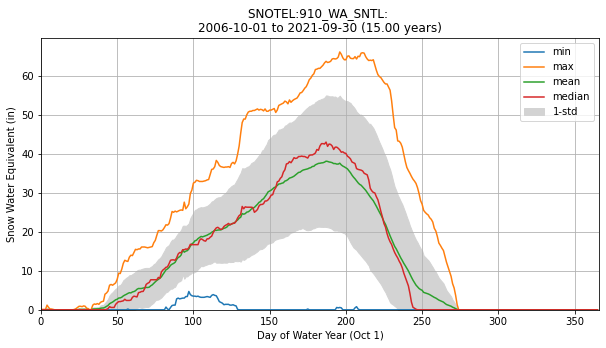

In [75]:
f,ax = plt.subplots(figsize=(10,5))

for stat in ['min','max','mean','median']:
    ax.plot(wteq_910_doy_stats.index, wteq_910_doy_stats[stat], label=stat)

ax.fill_between(wteq_910_doy_stats.index, wteq_910_doy_stats['mean'] - wteq_910_doy_stats['std'], wteq_910_doy_stats['mean'] + wteq_910_doy_stats['std'], \
                color='lightgrey', label='1-std')

title = f'SNOTEL:910_WA_SNTL: \n{wteq_910.index.min().date()} to {wteq_910.index.max().date()} ({nyears:.2f} years)'

ax.set_title(title)
ax.set_xlabel('Day of Water Year (Oct 1)')
ax.set_ylabel('Snow Water Equivalent (in)')
ax.grid()
ax.legend()
ax.set_xlim(0,366)
ax.set_ylim(bottom=0);

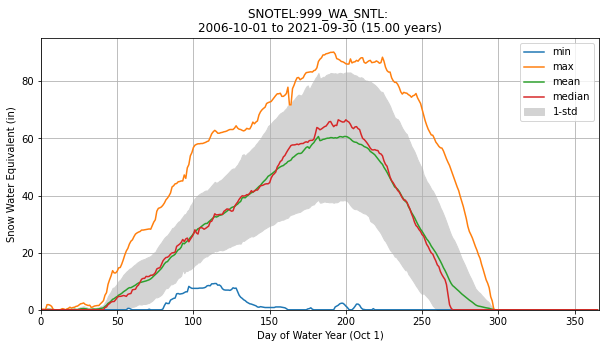

In [76]:
f,ax = plt.subplots(figsize=(10,5))

for stat in ['min','max','mean','median']:
    ax.plot(wteq_999_doy_stats.index, wteq_999_doy_stats[stat], label=stat)

ax.fill_between(wteq_999_doy_stats.index, wteq_999_doy_stats['mean'] - wteq_999_doy_stats['std'], wteq_999_doy_stats['mean'] + wteq_999_doy_stats['std'], \
                color='lightgrey', label='1-std')

title = f'SNOTEL:999_WA_SNTL: \n{wteq_999.index.min().date()} to {wteq_999.index.max().date()} ({nyears:.2f} years)'

ax.set_title(title)
ax.set_xlabel('Day of Water Year (Oct 1)')
ax.set_ylabel('Snow Water Equivalent (in)')
ax.grid()
ax.legend()
ax.set_xlim(0,366)
ax.set_ylim(bottom=0);

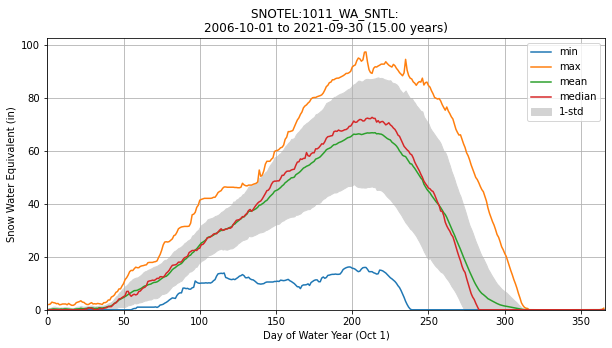

In [77]:
f,ax = plt.subplots(figsize=(10,5))

for stat in ['min','max','mean','median']:
    ax.plot(wteq_1011_doy_stats.index, wteq_1011_doy_stats[stat], label=stat)

ax.fill_between(wteq_1011_doy_stats.index, wteq_1011_doy_stats['mean'] - wteq_1011_doy_stats['std'], wteq_1011_doy_stats['mean'] + wteq_1011_doy_stats['std'], \
                color='lightgrey', label='1-std')

title = f'SNOTEL:1011_WA_SNTL: \n{wteq_1011.index.min().date()} to {wteq_1011.index.max().date()} ({nyears:.2f} years)'

ax.set_title(title)
ax.set_xlabel('Day of Water Year (Oct 1)')
ax.set_ylabel('Snow Water Equivalent (in)')
ax.grid()
ax.legend()
ax.set_xlim(0,366)
ax.set_ylim(bottom=0);

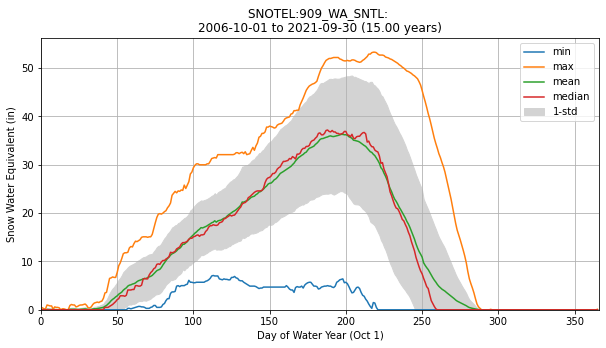

In [78]:
f,ax = plt.subplots(figsize=(10,5))

for stat in ['min','max','mean','median']:
    ax.plot(wteq_909_doy_stats.index, wteq_909_doy_stats[stat], label=stat)

ax.fill_between(wteq_909_doy_stats.index, wteq_909_doy_stats['mean'] - wteq_909_doy_stats['std'], wteq_909_doy_stats['mean'] + wteq_909_doy_stats['std'], \
                color='lightgrey', label='1-std')

title = f'SNOTEL:909_WA_SNTL: \n{wteq_909.index.min().date()} to {wteq_909.index.max().date()} ({nyears:.2f} years)'

ax.set_title(title)
ax.set_xlabel('Day of Water Year (Oct 1)')
ax.set_ylabel('Snow Water Equivalent (in)')
ax.grid()
ax.legend()
ax.set_xlim(0,366)
ax.set_ylim(bottom=0);

In [79]:
def wteq_start(df):
    col = df.columns[0]
    idx_min = df.groupby(['wy'])[col].transform(min) == df[col]
    wteq_start = df[df['dowy'] < 180][idx_min]
    wteq_start = wteq_start.drop_duplicates(subset=[col, 'wy'], keep='last')
    return wteq_start

In [80]:
def wteq_end(df):
    col = df.columns[0]
    idx_min = df.groupby(['wy'])[col].transform(min) == df[col]
    wteq_end = df[df['dowy'] > 180][idx_min]
    wteq_end = wteq_end.drop_duplicates(subset=[col, 'wy'], keep='first')
    return wteq_end

In [81]:
def wteq_peak(df):
    col = df.columns[0]
    idx_max = df.groupby(['wy'])[col].transform(max) == df[col]
    wteq_peak = df[idx_max]
    wteq_peak = wteq_peak.drop_duplicates(subset=[col, 'wy'], keep='last')
    return wteq_peak

In [84]:
start = wteq_start(wteq_1011)
peak = wteq_peak(wteq_1011)
end = wteq_end(wteq_1011)

/tmp/ipykernel_407/1026603799.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wteq_start = df[df['dowy'] < 180][idx_min]


In [123]:
peak

,SNOTEL:1011_WA_SNTL,dowy,wy
datetime,,,
2007-04-28 00:00:00+00:00,72.4,210,2007
2008-05-01 00:00:00+00:00,73.3,214,2008
2009-05-18 00:00:00+00:00,72.3,230,2009
2010-05-10 00:00:00+00:00,57.7,222,2010
2011-05-17 00:00:00+00:00,89.1,229,2011
2012-04-26 00:00:00+00:00,97.4,209,2012
2013-05-03 00:00:00+00:00,81.4,215,2013
2014-05-12 00:00:00+00:00,85.0,224,2014
2015-04-16 00:00:00+00:00,16.2,198,2015


In [124]:
station = peak.columns[0]
station

'SNOTEL:1011_WA_SNTL'

In [169]:
x = end.wy    # using x for shorthand below
y = end.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 3294.3405
B1 : -1.4964
R^2 : 0.138
R : -0.371
stderr : 1.037


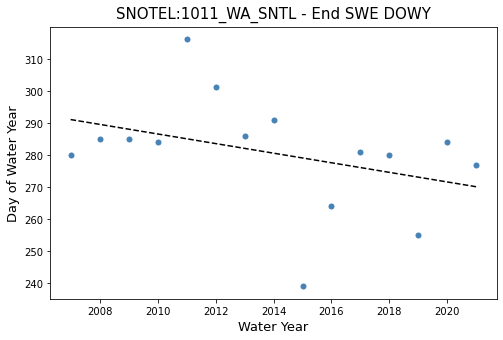

In [170]:
x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(8,5))
plt.plot(x,y,'steelblue', linestyle='none', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - End SWE DOWY', fontsize=15, y=1.01)

plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

In [171]:
x = peak.wy    # using x for shorthand below
y = peak.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 2499.6619
B1 : -1.1357
R^2 : 0.188
R : -0.434
stderr : 0.655


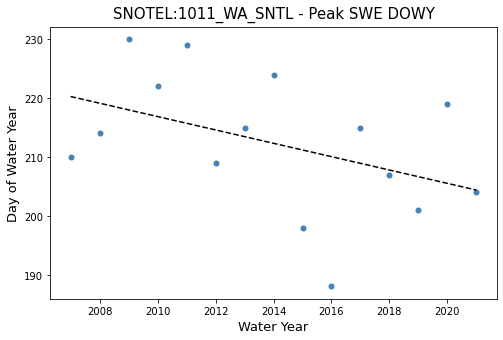

In [172]:
x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(8,5))
plt.plot(x,y, 'steelblue', linestyle='none', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Peak SWE DOWY', fontsize=15, y=1.01)

plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

<AxesSubplot:xlabel='dowy'>

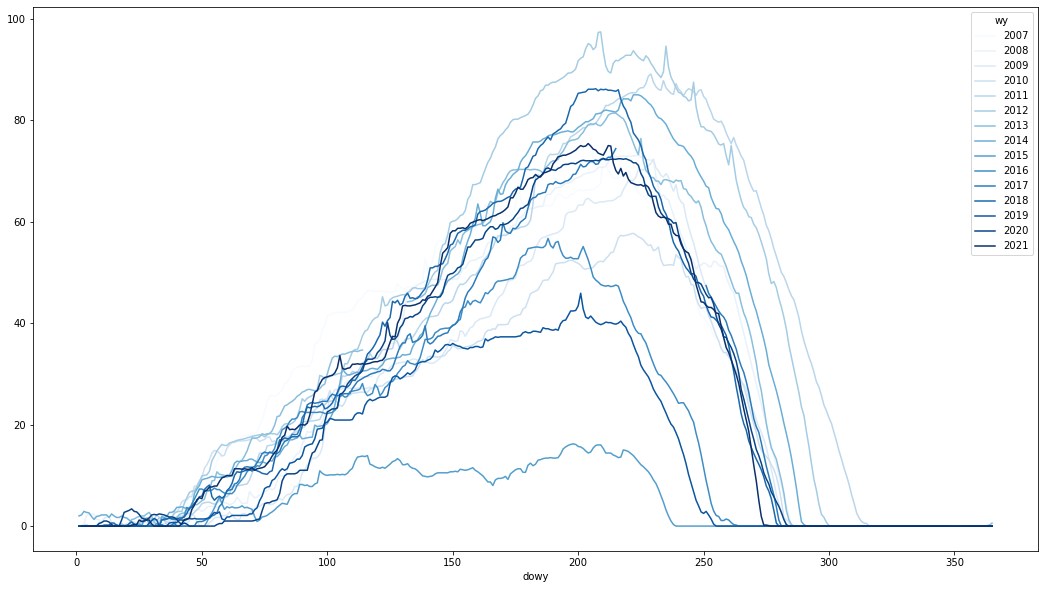

In [173]:
piv = pd.pivot_table(wteq_1011, index=('dowy'), columns=['wy'], values=wteq_1011.columns[0])
piv.plot(figsize=(18,10), cmap='Blues')